In [14]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
import yfinance as yf

# Sentiment Analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize


In [19]:
URL = 'https://news.google.com/search?q=PLTR&hl=no&gl=NO&ceid=NO%3Ano'

page = requests.get(URL)

soup = BeautifulSoup(page.content, 'html.parser')

results = soup.find_all('div', class_='NiLAwe y6IFtc R7GTQ keNKEd j7vNaf nID9nc')

news = []

for result in results:
    title = result.find('h3', class_='ipQwMb ekueJc RD0gLb').text
    link = result.find('a', href=True)['href']
    # get datetime
    datestr = result.find('time', class_='WW6dff uQIVzc Sksgp slhocf')['datetime']
    datetime = datestr.split('T')[0]
    news.append([title, link, datetime])

df = pd.DataFrame(news, columns=['title', 'link', 'date'])
# set index to date
# convert date to datetime
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# get sentiment score for all news
sid = SentimentIntensityAnalyzer()

df['sentiment_score'] = df['title'].apply(lambda x: sid.polarity_scores(x)['compound'])

df.sort_index(inplace=True)

display(df)

,title,link,sentiment_score
date,,,
2023-04-14,Is Trending Stock Palantir Technologies Inc. (...,./articles/CBMiVmh0dHBzOi8vZmluYW5jZS55YWhvby5...,0.0
2023-04-26,Palantir Technologies Inc. (PLTR) Flat As Mark...,./articles/CBMiUWh0dHBzOi8vZmluYW5jZS55YWhvby5...,0.0
2023-04-28,Here is What to Know Beyond Why Palantir Techn...,./articles/CBMiU2h0dHBzOi8vZmluYW5jZS55YWhvby5...,0.0
2023-05-03,Palantir Technologies Inc. (PLTR) Stock Moves ...,./articles/CBMiUmh0dHBzOi8vZmluYW5jZS55YWhvby5...,0.0
2023-05-08,Palantir Technologies Inc. (PLTR) Q1 Earnings ...,./articles/CBMiT2h0dHBzOi8vZmluYW5jZS55YWhvby5...,0.0
...,...,...,...
2023-11-20,Why Is Palantir (PLTR) Stock Up 5% Today?,./articles/CBMiSGh0dHBzOi8vaW52ZXN0b3JwbGFjZS5...,0.0
2023-11-20,Why Palantir (PLTR) Stock Is Trading Up Today,./articles/CBMiTWh0dHBzOi8vZmluYW5jZS55YWhvby5...,0.0
2023-11-21,乘上AI東風Palantir(PLTR.US)成“香餑餑” 提供者智通財經,./articles/CBMiPmh0dHBzOi8vaGsuaW52ZXN0aW5nLmN...,0.0


[*********************100%%**********************]  1 of 1 completed


C:\Users\joneh\AppData\Local\Temp\ipykernel_5044\1110763751.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stock['returns'] = np.log(stock['Adj Close']).diff()


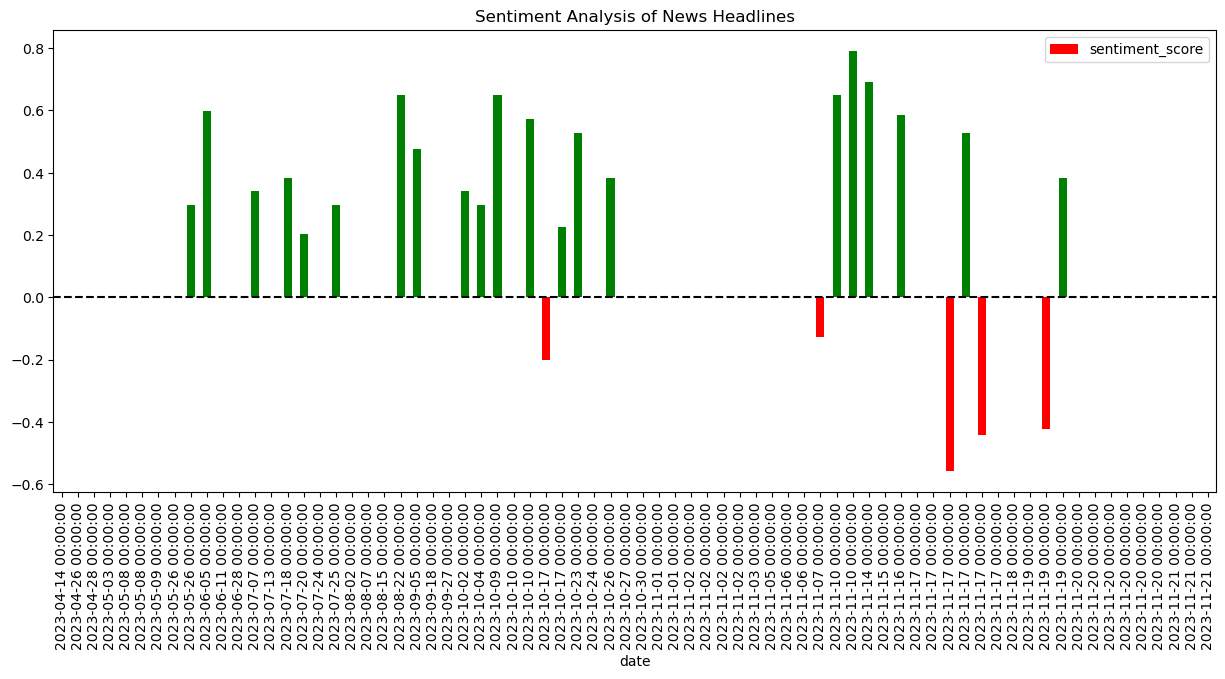

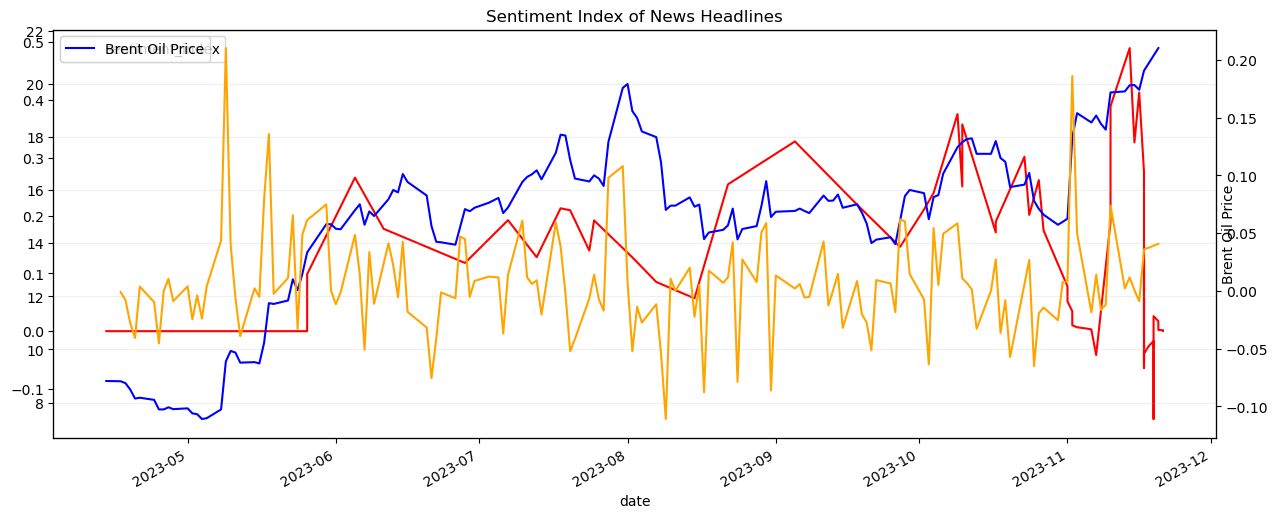

In [27]:
df['color'] = np.where(df['sentiment_score'] > 0, 'green', 'red')

df.plot.bar(y='sentiment_score', color=df['color'], figsize=(15, 6), title='Sentiment Analysis of News Headlines')
plt.axhline(y=0, color='black', linestyle='--')
# create sentiment index time series with EMA

df['sentiment_index'] = df['sentiment_score'].ewm(span=5, adjust=False).mean()

fig, ax = plt.subplots(figsize=(15, 6))

df.plot(y='sentiment_index', color=df['color'], figsize=(15, 6), title='Sentiment Index of News Headlines', ax=ax)

ax2 = ax.twinx()
ax3 = ax2.twinx()

stock = yf.download('PLTR', start=df.index[0], end=df.index[-1], interval='1d')[['Adj Close']]
stock['returns'] = np.log(stock['Adj Close']).diff()

stock['Adj Close'].plot(ax=ax2, color='blue', label='Brent Oil Price')
stock['returns'].plot(ax=ax3, color='orange', label='Brent Oil Return')
ax2.set_ylabel('Brent Oil Price')
ax2.legend(loc='upper left')
ax2.grid(alpha=0.2)

plt.show()
